In questo notebook simuleremo il conclave papale come un processo iterativo di votazione tra cardinali. Ogni cardinale ha preferenze personali su un insieme di candidati e appartiene a un gruppo (coalizione) che ne influenza il comportamento. Le votazioni si ripetono finché un candidato non raggiunge la soglia dei due terzi più uno dei voti. Il modello incorpora effetti dinamici come pressione sociale, coerenza di gruppo, memoria individuale e penalizzazione dei candidati trascurati.

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random

# Parametri del modello
N = 133  # numero di cardinali
M = 18   # numero di candidati
G = 8   # numero di gruppi ("coalizioni")

# Parametri dinamici

gamma = 0.50
delta = 0.2
k = 12
p = 0.4

# Soglia per eleggere un candidato (2/3 + 1)
#soglia = math.ceil((2 * N) / 3 + 1)
soglia=89

### Parametri e formula di aggiornamento

I parametri del modello regolano la dinamica delle preferenze dei cardinali nel tempo:

- **$\gamma$ (gamma)** rappresenta l'influenza del gruppo: maggiore è gamma, più un cardinale si allinea con la media del suo gruppo.
- **$\delta$ (delta)** introduce una penalizzazione per i candidati che ricevono pochi voti per più turni consecutivi.
- **$k$** è il numero di turni consecutivi in cui un candidato deve risultare trascurato per attivare la penalizzazione.
- **$p$** definisce la soglia relativa (in termini di percentuale di voti sul totale) sotto la quale un candidato è considerato ignorato.

La formula di aggiornamento per la propensione $x_{ij}^{(t)}$ del cardinale $i$ verso il candidato $j$ al turno $t+1$ avviene in tre fasi.

---

**1. Calcolo del valore grezzo (non ancora normalizzato):**

$$
x_{ij}^{\text{raw}} = (1 - \alpha(t) - \beta(t) - \gamma - \delta \cdot \chi_j^{(t)}) \cdot x_{ij}^{(t)} + \alpha(t) \cdot \frac{v_j^{(t)}}{N} + \beta(t) \cdot x_{ij}^{(0)} + \gamma \cdot \bar{x}_{g(i)j}^{(t)}
$$

dove:
- $\alpha(t)$ cresce nel tempo (influenza sociale),
- $\beta(t) = \text{costante} - \alpha(t)$ decresce nel tempo (fedeltà alla preferenza iniziale),
- $\chi_j^{(t)} \in \{0, 1\}$ indica se il candidato $j$ è stato ignorato negli ultimi $k$ turni,
- $\bar{x}_{g(i)j}^{(t)}$ è la media delle preferenze dei membri del gruppo di appartenenza di $i$.

---

**2. Normalizzazione del vettore grezzo:**

$$
x_{i}^{\text{raw}} \leftarrow \frac{x_{i}^{\text{raw}}}{\sum_j x_{ij}^{\text{raw}}}
$$

---

**3. Applicazione dell'inerzia ideologica:**

$$
x_{ij}^{(t+1)} = (1 - \eta) \cdot x_{ij}^{\text{raw}} + \eta \cdot x_{ij}^{(t)}
$$

dove $\eta \in [0, 1]$ è il coefficiente di inerzia, che modera i cambiamenti tra un turno e il successivo.

---

**4. (Facoltativo)**: Una seconda normalizzazione può essere applicata per sicurezza numerica, assicurando che $\sum_j x_{ij}^{(t+1)} = 1$.





### Preferenze Iniziali

Le preferenze iniziali dei cardinali vengono generate a partire da un centroide comune per ciascun gruppo, in modo da riflettere una certa coerenza ideologica tra membri della stessa coalizione. Ogni centroide viene perturbato con un rumore gaussiano per introdurre variabilità individuale. I vettori risultanti sono poi normalizzati affinché ogni cardinale abbia una distribuzione di probabilità sulle opzioni disponibili. 
Queste preferenze iniziali rappresentano lo stato $x_{ij}^{(0)}$, e vengono copiate come punto di partenza per il primo turno.

In [51]:
# Estrai gli ID dei gruppi effettivi
group_ids = set(group_assignments.values())

# Crea un centroide per ogni gruppo presente
group_centroids = {
    g: np.random.dirichlet(np.ones(M))
    for g in group_ids
}

# Genera preferenze iniziali per ogni cardinale
x_init = np.zeros((N, M))
for i in range(N):
    g = group_assignments[i]
    noise = np.random.normal(0, 0.1, size=M)
    noisy_pref = group_centroids[g] + noise
    noisy_pref = np.clip(noisy_pref, 0.0001, None)
    x_init[i] = noisy_pref / np.sum(noisy_pref)

x_current = x_init.copy()


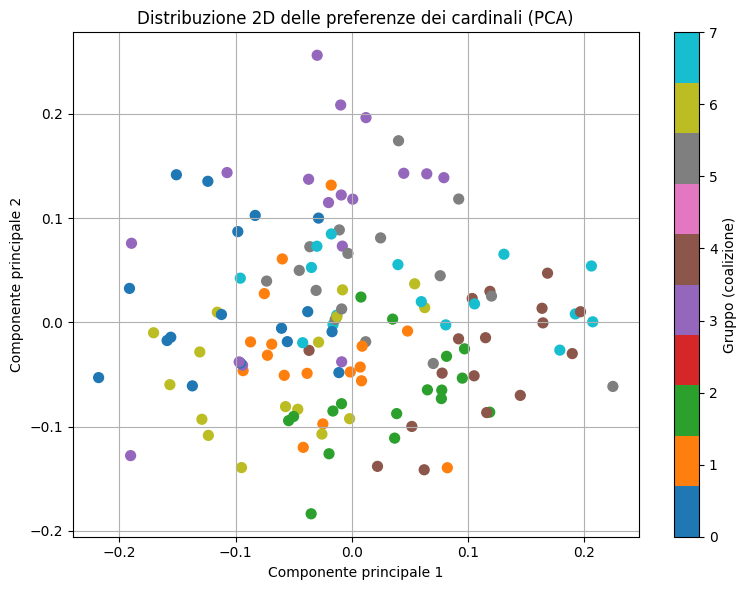

In [52]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Riduci i vettori x_i da M dimensioni a 2
pca = PCA(n_components=2)
coords_2d = pca.fit_transform(x_current)

# Colore per ogni gruppo
group_colors = [group_assignments[i] for i in range(N)]

# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(coords_2d[:, 0], coords_2d[:, 1], c=group_colors, cmap='tab10', s=50)
plt.title("Distribuzione 2D delle preferenze dei cardinali (PCA)")
plt.xlabel("Componente principale 1")
plt.ylabel("Componente principale 2")
plt.colorbar(scatter, label="Gruppo (coalizione)")
plt.grid(True)
plt.tight_layout()
plt.show()

### Assegnazione dei gruppi

Ogni cardinale viene assegnato casualmente a uno dei G gruppi (coalizioni). I gruppi sono bilanciati il più possibile e la randomizzazione può essere controllata con un seme per garantire ripetibilità. Il risultato è un dizionario che associa ogni cardinale a un gruppo.

In [53]:
# Funzione per assegnare N cardinali in G gruppi
def assegna_gruppi(N, G, seed=None):
    if seed is not None:
        random.seed(seed)
    
    cardinali = list(range(N))
    random.shuffle(cardinali)
    
    group_assignments = {}
    for i, cardinale in enumerate(cardinali):
        group = i % G
        group_assignments[cardinale] = group
    
    return group_assignments

# Assegna i gruppi
group_assignments = assegna_gruppi(N, G, seed=42)

### Inizializzazione dello storico dei voti

Una lista vuota viene creata per salvare il numero di voti ottenuti da ciascun candidato a ogni turno, utile per l'analisi dinamica e la penalizzazione dei candidati trascurati.

In [54]:
# Per tracciare i voti passati dei candidati
vote_history = []

### Calcolo dei voti

Ad ogni turno, ogni cardinale vota per il candidato a cui è più propenso (cioè con il valore massimo nel vettore \( x_i \)). La funzione restituisce il vettore di voti individuali.

In [55]:
# Funzione per calcolare voti al turno t
def compute_votes(x):
    return np.argmax(x, axis=1)

### Parametri dinamici: alpha(t) e beta(t)

Nel modello assumiamo che il peso totale attribuito alla pressione sociale e alla memoria delle preferenze iniziali rimanga costante nel tempo. Per questo motivo poniamo $\alpha(t) + \beta(t) = c$, dove $c$ è una costante scelta (es. 0.25).

Questo approccio riflette un principio di conservazione dell'influenza complessiva, ma consente di modellare una dinamica realistica:

- $\alpha(t)$ (influenza sociale) cresce nel tempo, simulando la pressione crescente verso il compromesso man mano che il conclave si prolunga.
- $\beta(t)$ (attaccamento alle preferenze iniziali) decresce di pari passo, riflettendo una progressiva disponibilità a rivedere le proprie posizioni.

In questo modo i cardinali partono fedeli alle loro convinzioni, ma diventano via via più inclini a convergere su un candidato condiviso.


In [56]:
# Evoluzione dinamica dei parametri alpha (influenza sociale) e beta (memoria personale)

def alpha_t(t, max_turns=70, alpha_max=0.2):
    """
    Alpha cresce linearmente fino a un massimo.
    Rappresenta l'influenza sociale (pressione al consenso).
    """
    return min(t / max_turns * alpha_max, alpha_max)

def beta_t(t, alpha_max=0.2, total_influence=0.25, max_turns=70):
    """
    Beta decresce in modo da mantenere costante la somma alpha + beta.
    Rappresenta la fedeltà alle preferenze iniziali (memoria ideologica).
    """
    return total_influence - alpha_t(t, max_turns, alpha_max)


### Aggiornamento dinamico delle preferenze

La funzione `update_x` calcola il nuovo vettore di propensione al voto per ogni cardinale, combinando diversi fattori:

- **Memoria del turno precedente**, pesata da $(1 - \alpha - \beta - \gamma - \delta)$;
- **Influenza sociale**, proporzionale al numero di voti ricevuti dal candidato ($\alpha$);
- **Preferenza iniziale personale**, che decresce nel tempo con $\beta$;
- **Coerenza di gruppo**, attraverso la media delle preferenze degli altri membri ($\gamma$);
- **Penalizzazione**, se il candidato è trascurato da almeno $k$ turni ($\delta$);
- **Inerzia ideologica**, che smorza i cambiamenti improvvisi.

Tutti i pesi sono dinamici o condizionati dal tempo e dalla storia dei voti. Al termine dell’aggiornamento, ogni vettore viene normalizzato per rappresentare una distribuzione di probabilità.


In [57]:
# Funzione per aggiornare x con penalità, coerenza di gruppo e dinamiche sociali/ideologiche
def update_x(x, x0, vote_counts, history, t):
    new_x = np.zeros_like(x)
    alpha_dynamic = alpha_t(t)
    beta_dynamic = beta_t(t)
    inertia = 0.2  # coefficiente di inerzia ideologica

    # Calcolo media del gruppo per ciascun candidato
    group_means = {}
    for g in range(G):
        members = [i for i, grp in group_assignments.items() if grp == g]
        group_means[g] = np.mean(x[members], axis=0) if members else np.zeros(M)

    # Identifica candidati penalizzati
    penalty_flags = np.zeros(M)
    if t >= k:
        for j in range(M):
            low_votes = [v[j] < p * N for v in history[-k:]]
            if all(low_votes):
                penalty_flags[j] = 1

    for i in range(N):
        g = group_assignments[i]
        x_raw = np.zeros(M)

        for j in range(M):
            memory = (1 - alpha_dynamic - beta_dynamic - gamma - delta * penalty_flags[j]) * x[i, j]
            social = alpha_dynamic * (vote_counts[j] / N)
            personal = beta_dynamic * x0[i, j]
            group = gamma * group_means[g][j]
            x_raw[j] = memory + social + personal + group

        # 1. Normalizza x_raw
        x_raw /= np.sum(x_raw)

        # 2. Applica inerzia ideologica rispetto al turno precedente
        new_x[i] = (1 - inertia) * x_raw + inertia * x[i]

        # 3. (Opzionale) normalizza di nuovo per sicurezza
        new_x[i] /= np.sum(new_x[i])

    return new_x



### Simulazione del conclave

La simulazione procede per turni, durante i quali ogni cardinale vota per il candidato a cui è attualmente più propenso. Dopo ogni turno:

- Si contano i voti ricevuti da ciascun candidato.
- Si stampano i vettori di preferenze aggiornati di tutti i cardinali.
- Se un candidato ottiene almeno $\lceil \frac{2N}{3} + 1 \rceil$ voti, la simulazione si interrompe e il candidato viene eletto.
- In caso contrario, le preferenze vengono aggiornate secondo le dinamiche del modello e si passa al turno successivo.

Il ciclo termina automaticamente quando viene eletto un candidato, simulando il comportamento del conclave reale.



✅ Candidato 9 è stato eletto con 108 voti dopo 21 turni.


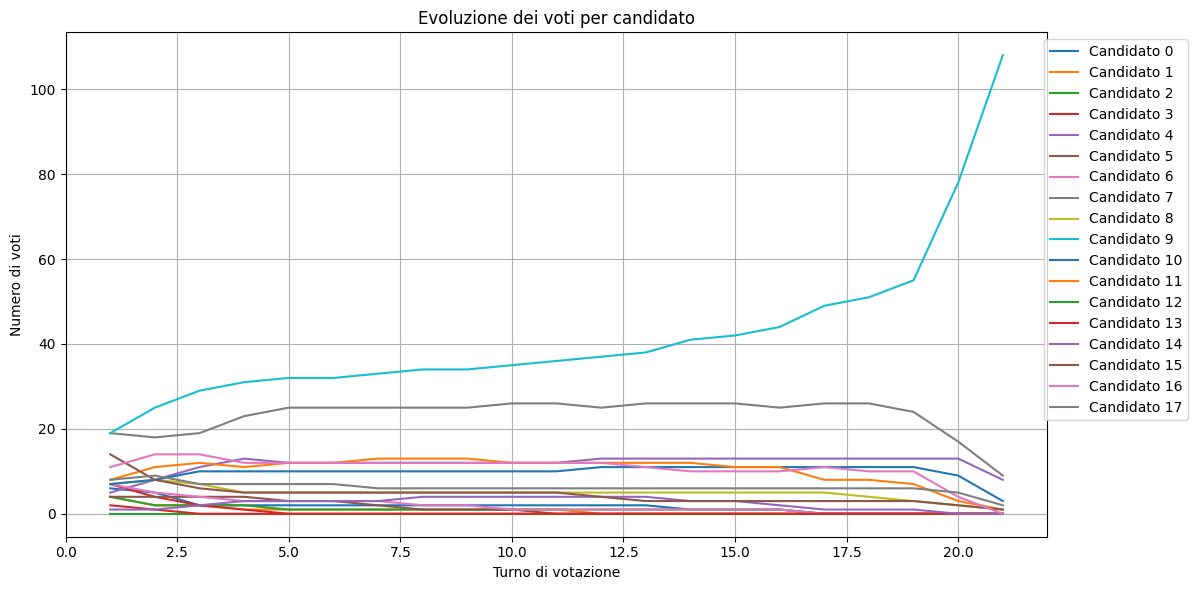

In [58]:
# Simulazione con stop se un candidato raggiunge la soglia
turno = 0
while True:
    # print(f"\n--- Turno {turno + 1} ---")

    votes = compute_votes(x_current)
    vote_counts = np.bincount(votes, minlength=M)
    vote_history.append(vote_counts)

    # print("Voti per candidato:")
    # for j in range(M):
    #     print(f"  Candidato {j}: {vote_counts[j]} voti")

    # print("\nPreferenze dei cardinali:")
    # for i in range(N):
    #     prefs = ", ".join([f"{x_current[i, j]:.3f}" for j in range(M)])
    #     print(f"  Cardinale {i}: [{prefs}]")

    for j in range(M):
        if vote_counts[j] >= soglia:
            print(f"\n✅ Candidato {j} è stato eletto con {vote_counts[j]} voti dopo {turno + 1} turni.")
            break
    else:
        x_current = update_x(x_current, x_init, vote_counts, vote_history, turno)
        turno += 1
        continue
    break

# Grafico finale: evoluzione voti per candidato
vote_array = np.array(vote_history)
plt.figure(figsize=(12, 6))
for j in range(M):
    plt.plot(range(1, len(vote_array) + 1), vote_array[:, j], label=f'Candidato {j}')
plt.xlabel('Turno di votazione')
plt.ylabel('Numero di voti')
plt.title('Evoluzione dei voti per candidato')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1.0), ncol=1)
plt.grid(True)
plt.tight_layout()
plt.show()




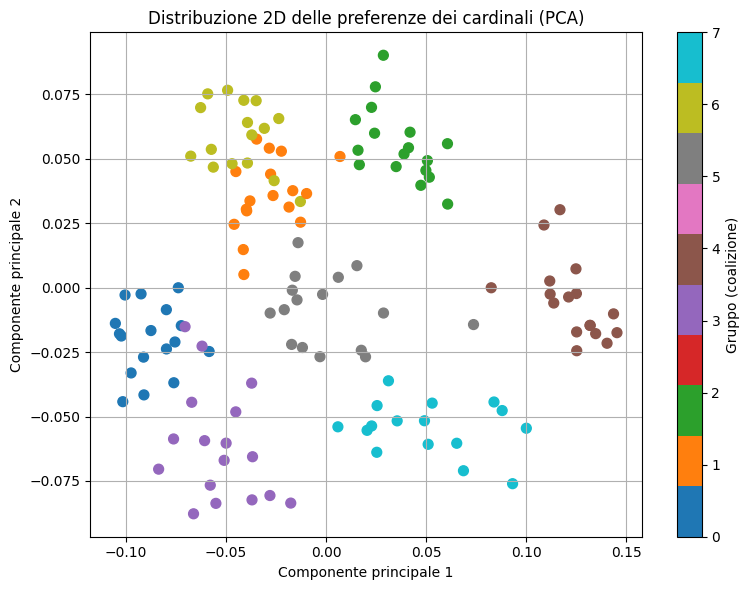

In [59]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Riduci i vettori x_i da M dimensioni a 2
pca = PCA(n_components=2)
coords_2d = pca.fit_transform(x_current)

# Colore per ogni gruppo
group_colors = [group_assignments[i] for i in range(N)]

# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(coords_2d[:, 0], coords_2d[:, 1], c=group_colors, cmap='tab10', s=50)
plt.title("Distribuzione 2D delle preferenze dei cardinali (PCA)")
plt.xlabel("Componente principale 1")
plt.ylabel("Componente principale 2")
plt.colorbar(scatter, label="Gruppo (coalizione)")
plt.grid(True)
plt.tight_layout()
plt.show()


### Definizione dei candidati papabili e delle coalizioni

In questa sezione costruiamo una rappresentazione strutturata delle preferenze iniziali dei cardinali elettori, tenendo conto delle dinamiche reali del conclave.

Abbiamo identificato **8 candidati papabili** con nome e collocazione ecclesiale nota, a cui si aggiungono **1–2 outsider** generici per simulare la possibilità di emergere di candidati di compromesso. Il numero totale di candidati è quindi ridotto a **$M = 9$ o $M = 10$**, rendendo il modello più realistico e leggibile.

Le coalizioni (gruppi) rappresentano grandi famiglie ecclesiali o aree di influenza teologica, culturale o geopolitica. Abbiamo identificato **$G = 8$** gruppi:

- Bergogliani globali
- Progressisti europei
- Curiali moderati
- Curia riformista
- Africani sociali
- Conservatori europei
- Mediatori interculturali
- Indipendenti / misti

Ogni gruppo è caratterizzato da un **centroide**: un vettore in $\mathbb{R}^{M}$ che rappresenta la propensione media del gruppo a sostenere ciascun candidato. I valori più alti del centroide indicano candidati ideologicamente o strategicamente affini.

Per esempio, il gruppo "Bergogliani globali" mostra una preferenza marcata per Luis Antonio Tagle, ma anche una certa apertura verso candidati progressisti o del Sud globale (Zuppi, Ambongo, Aveline, Prevost). All'opposto, i "Conservatori europei" si concentrano su Péter Erdő e in parte su Parolin.

Per evitare che un gruppo assegni probabilità zero a certi candidati, qualsiasi parte residua del vettore non assegnata ai candidati preferiti viene distribuita uniformemente tra gli altri. In questo modo, ogni centroide riflette tendenze forti ma lascia spazio a minimi livelli di apertura e compromesso.



In [81]:
candidati_papabili = {
    0: "Pietro Parolin",           # Curiali moderati
    1: "Luis Antonio Tagle",       # Bergogliani globali
    2: "Matteo Zuppi",             # Progressisti europei
    3: "Robert Francis Prevost",   # Curia riformista / transnazionale
    4: "Jean-Marc Aveline",        # Intellettuali interculturali
    5: "Fridolin Ambongo Besungu", # Africani sociali
    6: "Péter Erdő",               # Conservatori europei
    7: "Pierbattista Pizzaballa"   # Medio Oriente / Dialogo
}


gruppi_coalizioni = {
    0: "Bergogliani globali",
    1: "Progressisti europei",
    2: "Curiali moderati",
    3: "Curia riformista",
    4: "Africani sociali",
    5: "Conservatori europei",
    6: "Mediatori internazionali / interculturali",
    7: "Altri / Indipendenti"
}


candidati_gruppo = {
    0: 2,  # Parolin → Curiali moderati
    1: 0,  # Tagle → Bergogliani globali
    2: 1,  # Zuppi → Progressisti europei
    3: 3,  # Prevost → Curia riformista
    4: 6,  # Aveline → Mediatori/interculturali
    5: 4,  # Ambongo → Africani sociali
    6: 5,  # Erdő → Conservatori europei
    7: 6   # Pizzaballa → Mediatori/interculturali
}


import numpy as np

M = 10  # numero candidati
G = 8   # numero gruppi

group_centroids = np.zeros((G, M))

# Indici candidati noti
PAROLIN = 0
TAGLE = 1
ZUPPI = 2
PREVOST = 3
AVELINE = 4
AMBONGO = 5
ERDO = 6
PIZZABALLA = 7

# Funzione per costruire ogni centroide
def set_group_preferences(centroid, preferenze):
    totale_assegnato = sum(preferenze.values())
    residuo = 1.0 - totale_assegnato
    non_specificati = [i for i in range(M) if i not in preferenze]
    base = residuo / len(non_specificati)
    
    for j in range(M):
        if j in preferenze:
            centroid[j] = preferenze[j]
        else:
            centroid[j] = base
    return centroid

# Bergogliani globali
group_centroids[0] = set_group_preferences(group_centroids[0], {
    TAGLE: 0.2,
    ZUPPI: 0.1,
    PREVOST: 0.1,
    AMBONGO: 0.1,
    AVELINE: 0.1
})

# Progressisti europei
group_centroids[1] = set_group_preferences(group_centroids[1], {
    ZUPPI: 0.2,
    TAGLE: 0.1,
    AVELINE: 0.1
})

# Curiali moderati
group_centroids[2] = set_group_preferences(group_centroids[2], {
    PAROLIN: 0.3,
    PREVOST: 0.3
})

# Curia riformista
group_centroids[3] = set_group_preferences(group_centroids[3], {
    PREVOST: 0.2,
    TAGLE: 0.1,
    ZUPPI: 0.1
})

# Africani sociali
group_centroids[4] = set_group_preferences(group_centroids[4], {
    AMBONGO: 0.5,
    TAGLE: 0.1
})

# Conservatori europei
group_centroids[5] = set_group_preferences(group_centroids[5], {
    ERDO: 0.4,
    PAROLIN: 0.2
})

# Interculturali / mediatori
group_centroids[6] = set_group_preferences(group_centroids[6], {
    AVELINE: 0.3,
    PIZZABALLA: 0.3,
    ZUPPI: 0.1
})

# Indipendenti / misti
group_centroids[7] = set_group_preferences(group_centroids[7], {
    8: 0.1,
})


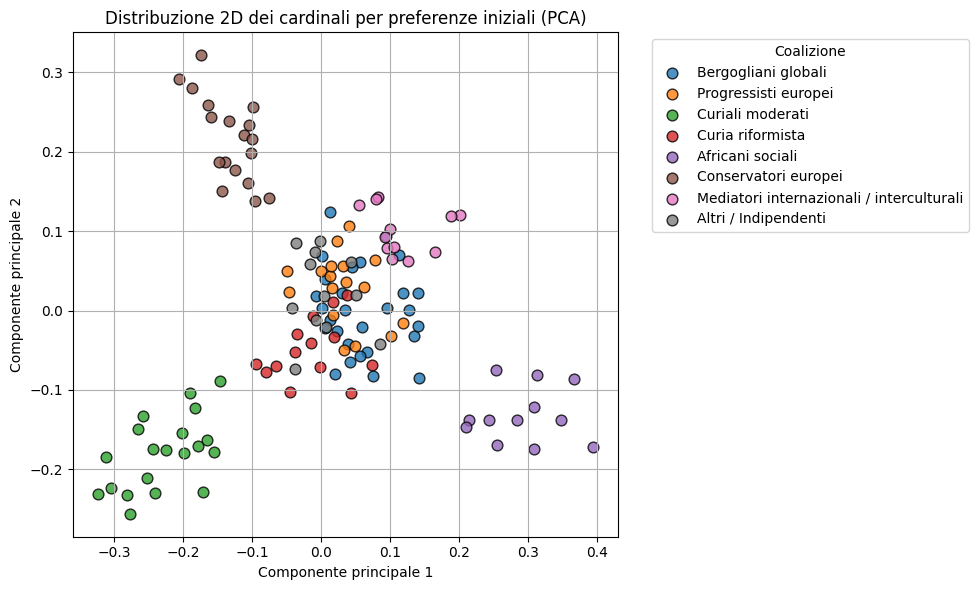

In [82]:
N = 133
M=10
gruppo_cardinali = {
    0: 28,  # Bergogliani globali
    1: 17,  # Progressisti europei
    2: 20,  # Curiali moderati
    3: 14,  # Curia riformista
    4: 12,  # Africani sociali
    5: 18,  # Conservatori europei
    6: 12,  # Interculturali
    7: 12   # Indipendenti
}
assert sum(gruppo_cardinali.values()) == N


np.random.seed(42)  # per riproducibilità

x_init = np.zeros((N, M))
group_assignments = {}
current_index = 0
sigma = 0.05  # deviazione standard del rumore

for g in range(G):
    n_g = gruppo_cardinali[g]
    centroide = group_centroids[g]

    for _ in range(n_g):
        # Rumore attorno al centroide
        noise = np.random.normal(0, sigma, size=M)
        noisy = centroide + noise

        # Clip e normalizzazione
        noisy = np.clip(noisy, 0.0001, None)
        x_init[current_index] = noisy / np.sum(noisy)

        # Assegna il cardinale al gruppo
        group_assignments[current_index] = g
        current_index += 1

x_current = x_init.copy()

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Supponiamo che x_init sia la tua matrice di preferenze iniziali (N x M)
# e group_assignments sia un dizionario che mappa ogni cardinale al suo gruppo

# Riduzione dimensionale a 2D con PCA
pca = PCA(n_components=2)
coords_2d = pca.fit_transform(x_init)

# Colori per gruppi (puoi personalizzare la mappa dei colori)
group_labels = list(gruppi_coalizioni.values())
num_groups = len(group_labels)
cmap = plt.get_cmap('tab10')  # Mappa di colori con almeno 10 colori distinti
colors = [cmap(i) for i in range(num_groups)]

plt.figure(figsize=(10, 6))

# Traccia i punti per ciascun gruppo separatamente
for group_id in range(num_groups):
    indices = [i for i, g in group_assignments.items() if g == group_id]
    plt.scatter(coords_2d[indices, 0], coords_2d[indices, 1],
                color=colors[group_id], label=group_labels[group_id],
                s=60, edgecolor='k', alpha=0.8)

plt.title("Distribuzione 2D dei cardinali per preferenze iniziali (PCA)")
plt.xlabel("Componente principale 1")
plt.ylabel("Componente principale 2")
plt.legend(title="Coalizione", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()



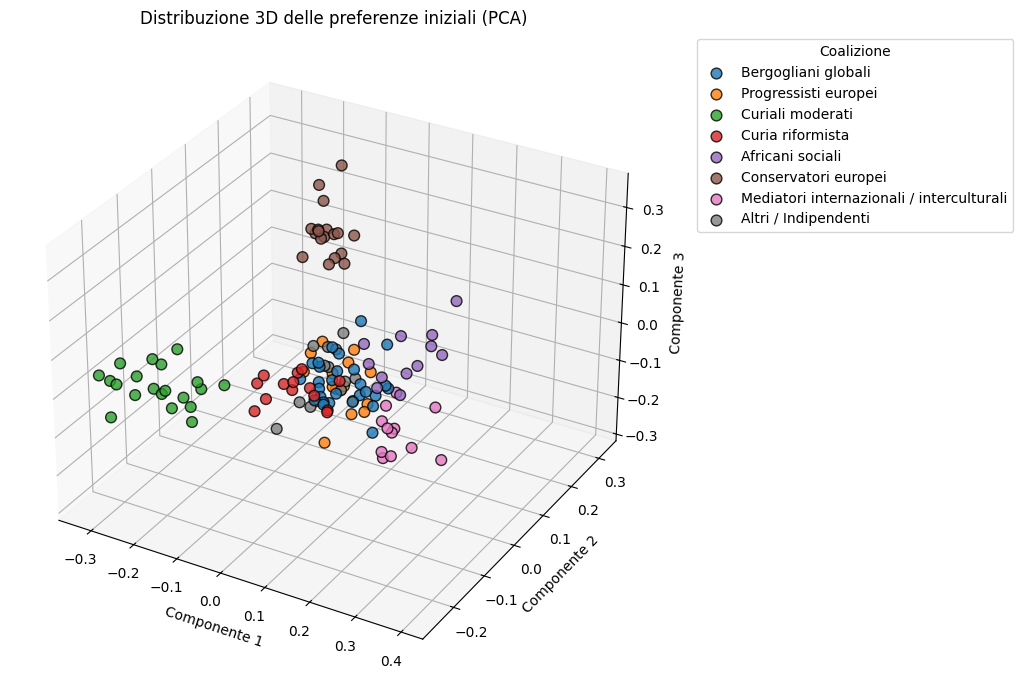

In [83]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Necessario per il 3D

# Riduzione dimensionale a 3D
pca_3d = PCA(n_components=3)
coords_3d = pca_3d.fit_transform(x_init)

# Colori per gruppi
group_labels = list(gruppi_coalizioni.values())
num_groups = len(group_labels)
cmap = plt.get_cmap('tab10')
colors = [cmap(i) for i in range(num_groups)]

# Crea il grafico 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

for group_id in range(num_groups):
    indices = [i for i, g in group_assignments.items() if g == group_id]
    ax.scatter(coords_3d[indices, 0], coords_3d[indices, 1], coords_3d[indices, 2],
               color=colors[group_id], label=group_labels[group_id], s=60, edgecolor='k', alpha=0.8)

ax.set_title("Distribuzione 3D delle preferenze iniziali (PCA)")
ax.set_xlabel("Componente 1")
ax.set_ylabel("Componente 2")
ax.set_zlabel("Componente 3")
ax.legend(title="Coalizione", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Simulazione del Conclave: struttura iniziale e dinamiche evolutive

In questo modello, simuleremo l'elezione del papa all'interno di un conclave composto da 133 cardinali (N=133), suddivisi in 8 gruppi (coalizioni ideologiche o culturali) e chiamati a scegliere tra 18 candidati (M=10), di cui 8 con identità nota e 2 anonimi.

#### Configurazione iniziale

Ogni gruppo è caratterizzato da un **centroide** (vettore in $\mathbb{R}^{10}$) che rappresenta la distribuzione media delle preferenze del gruppo verso i candidati. Ogni cardinale viene generato a partire dal centroide del proprio gruppo, aggiungendo un **rumore gaussiano** con deviazione standard $\sigma = 0.15$, così da ottenere una certa variabilità interna (più ampia per gruppi eterogenei come gli Indipendenti).

Le preferenze iniziali $x_i^{(0)}$ vengono normalizzate affinché ogni vettore rappresenti una distribuzione di probabilità coerente.

#### Regole di aggiornamento delle preferenze

A ogni turno, ogni cardinale aggiorna le proprie preferenze $x_i^{(t)}$ secondo una combinazione di fattori:

- **Memoria del turno precedente** (quanto conserva della sua preferenza attuale)
- **Pressione sociale** proporzionale alla popolarità attuale di ciascun candidato ($\alpha$)
- **Fedeltà alle preferenze iniziali** ($\beta$)
- **Influenza del gruppo di appartenenza** ($\gamma$)
- **Penalizzazione dei candidati trascurati** ($\delta$)
- **Inerzia ideologica**: smorza l'aggiornamento avvicinandolo alla preferenza precedente

La formula grezza (prima della normalizzazione) è:

$$
x_{ij}^{\text{raw}} = (1 - \alpha - \beta - \gamma - \delta \cdot \chi_j^{(t)}) \cdot x_{ij}^{(t)} + \alpha \cdot \frac{v_j^{(t)}}{N} + \beta \cdot x_{ij}^{(0)} + \gamma \cdot \bar{x}_{g(i)j}^{(t)}
$$

Seguita da:

$$
x_{ij}^{(t+1)} = (1 - \eta) \cdot \text{normalize}(x_{ij}^{\text{raw}}) + \eta \cdot x_{ij}^{(t)}
$$

dove $\eta$ è il coefficiente di **inerzia ideologica**.

#### Dinamiche temporali di $\alpha$ e $\beta$

- $\alpha(t)$ cresce linearmente da un valore iniziale (es. 0.1) fino a un massimo (es. 0.3) in 30 turni, per rappresentare l'aumento della pressione al consenso.
- $\beta(t)$ decresce in modo complementare, mantenendo costante $\alpha + \beta = 0.3$.

#### Condizione di elezione

Il conclave termina non appena un candidato riceve almeno 89 voti (i due terzi + 1), coerentemente con le regole canoniche. I risultati raccolti indicano il numero di turni necessari all'elezione in ciascuna simulazione.

#### Obiettivo del modello

L'obiettivo è esplorare, in maniera realistica e parametrizzabile, le dinamiche emergenti nel conclave papale: polarizzazione, stabilità dei gruppi, compromessi, e velocità dell'elezione.


In [86]:
# Parametri fissati fuori dalla funzione
N = 133
M = 10
G = 9
gamma = 0.30
delta = 0.15
k = 8
p = 0.2
inertia = 0.1
soglia = 89
sigma = 0.15
total_influence = 0.4 #alfa+beta
alpha_start = 0.15
transition_turns = 28

# Funzioni alpha e beta globali
def alpha_t(t):
    progress = min(t / transition_turns, 1.0)
    return alpha_start + (total_influence - alpha_start) * progress

def beta_t(t):
    return total_influence - alpha_t(t)

def compute_votes(x):
    return np.argmax(x, axis=1)

def update_x(x, x0, vote_counts, history, t, group_assignments):
    new_x = np.zeros_like(x)
    alpha = alpha_t(t)
    beta = beta_t(t)
    group_means = {
        g: np.mean(x[[i for i in range(N) if group_assignments[i] == g]], axis=0)
        for g in range(G)
    }
    penalty_flags = np.zeros(M)
    if t >= k:
        for j in range(M):
            if all(v[j] < p * N for v in history[-k:]):
                penalty_flags[j] = 1

    for i in range(N):
        g = group_assignments[i]
        x_raw = np.zeros(M)
        for j in range(M):
            memory = (1 - alpha - beta - gamma - delta * penalty_flags[j]) * x[i, j]
            social = alpha * (vote_counts[j] / N)
            personal = beta * x0[i, j]
            group = gamma * group_means[g][j]
            x_raw[j] = memory + social + personal + group
        x_raw /= np.sum(x_raw)
        new_x[i] = (1 - inertia) * x_raw + inertia * x[i]
        new_x[i] /= np.sum(new_x[i])
    return new_x

# Funzione di simulazione
from collections import Counter


def simula_conclavi(n_simulazioni):
    risultati_votazioni = []
    vincitori = []

    for seed in range(n_simulazioni):
        np.random.seed(seed)
        group_ids = list(gruppo_cardinali.keys())
        group_assignments = {}
        x_init = np.zeros((N, M))
        index = 0

        # Costruisci preferenze realistiche da centroidi
        for g in group_ids:
            n_g = gruppo_cardinali[g]
            centroide = group_centroids[g]
            for _ in range(n_g):
                noise = np.random.normal(0, sigma, size=M)
                noisy = centroide + noise
                noisy = np.clip(noisy, 0.0001, None)
                x_init[index] = noisy / np.sum(noisy)
                group_assignments[index] = g
                index += 1

        x_current = x_init.copy()
        vote_history = []

        for turno in range(1000):
            votes = compute_votes(x_current)
            vote_counts = np.bincount(votes, minlength=M)
            vote_history.append(vote_counts)
            if any(v >= soglia for v in vote_counts):
                risultati_votazioni.append(turno + 1)
                vincitori.append(np.argmax(vote_counts))
                break
            x_current = update_x(x_current, x_init, vote_counts, vote_history, turno, group_assignments)

    return risultati_votazioni, vincitori




### Analisi dei risultati: distribuzione e durata del conclave

Dopo aver simulato un certo numero di conclavi (in questo caso 100), analizziamo la **distribuzione del numero di votazioni necessarie** per eleggere un papa.

#### Visualizzazione

Utilizziamo un **grafico a barre** per rappresentare quante volte ciascun numero di votazioni si è verificato nelle simulazioni. Questo ci permette di osservare la forma della distribuzione: simmetrica, sbilanciata, con outlier, ecc.

#### Statistiche riassuntive

Calcoliamo anche:
- **La media del numero di votazioni** necessarie per l’elezione,
- **La durata media in giorni**, assumendo che si tengano 4 votazioni al giorno (2 al mattino e 2 al pomeriggio), come avviene nei conclavi reali.

Questa analisi consente di confrontare il comportamento del nostro modello con i dati storici del conclave e di valutarne la coerenza e la plausibilità.


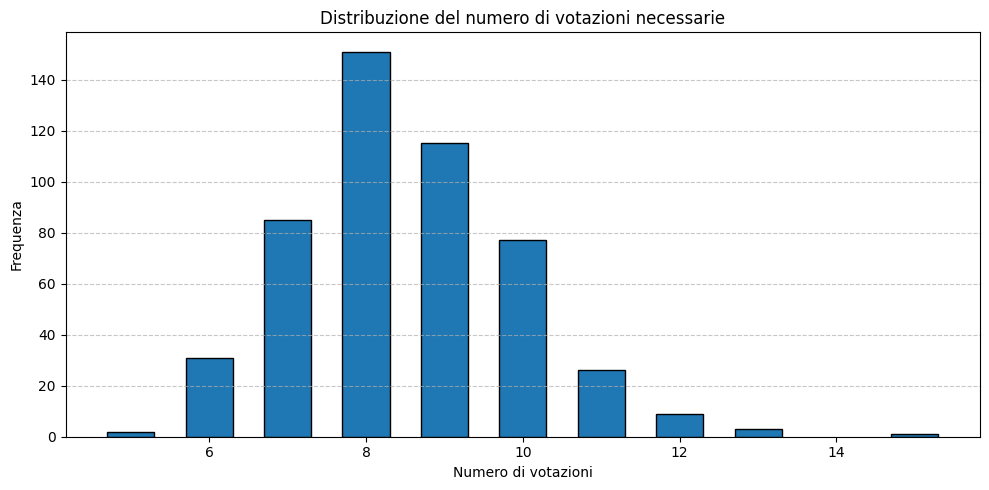

Media votazioni: 8.50
Media giorni: 2.13


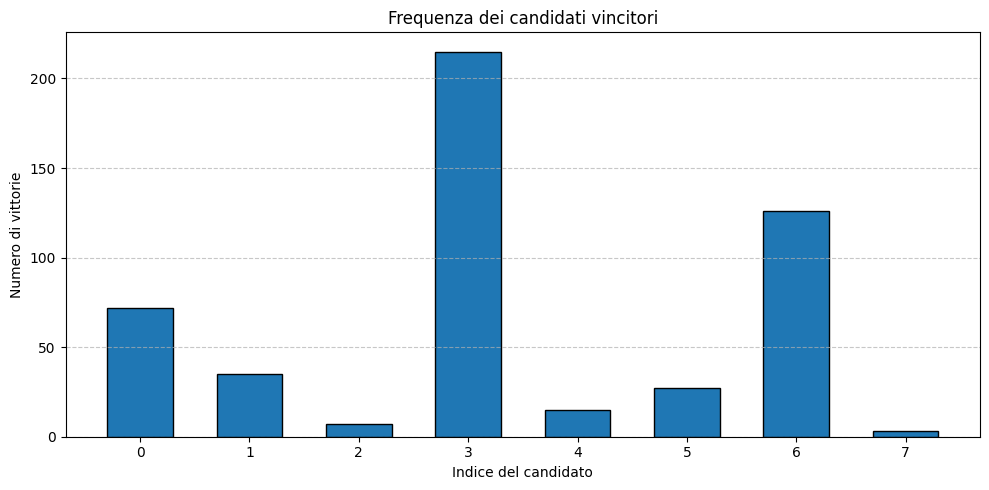

In [88]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Esegui le simulazioni
n_simulazioni = 500
risultati_votazioni, vincitori = simula_conclavi(n_simulazioni)

# Distribuzione del numero di votazioni necessarie
distribuzione_votazioni = Counter(risultati_votazioni)
voti = sorted(distribuzione_votazioni.items())
x = [item[0] for item in voti]
y = [item[1] for item in voti]

plt.figure(figsize=(10, 5))
plt.bar(x, y, width=0.6, edgecolor='black')
plt.xlabel("Numero di votazioni")
plt.ylabel("Frequenza")
plt.title("Distribuzione del numero di votazioni necessarie")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Statistiche
numero_votazioni = []
for voti, freq in distribuzione_votazioni.items():
    numero_votazioni.extend([voti] * freq)

media_votazioni = np.mean(numero_votazioni)
media_giorni = media_votazioni / 4

print(f"Media votazioni: {media_votazioni:.2f}")
print(f"Media giorni: {media_giorni:.2f}")

# Frequenza dei vincitori
frequenza_vincitori = Counter(vincitori)
candidati = list(frequenza_vincitori.keys())
frequenze = list(frequenza_vincitori.values())

plt.figure(figsize=(10, 5))
plt.bar(candidati, frequenze, width=0.6, edgecolor='black')
plt.xlabel("Indice del candidato")
plt.ylabel("Numero di vittorie")
plt.title("Frequenza dei candidati vincitori")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



In [ ]:
print("\nFrequenze:", Counter(vincitori))


Frequenze: Counter({3: 44, 6: 29, 0: 13, 1: 8, 5: 2, 2: 2, 7: 1, 4: 1})


In [89]:
# Determina il candidato con più vittorie
vincitore_frequente = max(frequenza_vincitori, key=frequenza_vincitori.get)
nome_vincitore = candidati_papabili.get(vincitore_frequente, f"Candidato {vincitore_frequente}")
vittorie = frequenza_vincitori[vincitore_frequente]

print(f"\n🏆 Il favorito per la vittoria è: {nome_vincitore}")
print(f"   → Eletto in {vittorie} su {n_simulazioni} simulazioni")
print(f"   → Durata media del conclave: {media_giorni:.2f} giorni ({media_votazioni:.2f} votazioni)")


🏆 Il favorito per la vittoria è: Robert Francis Prevost
   → Eletto in 215 su 500 simulazioni
   → Durata media del conclave: 2.13 giorni (8.50 votazioni)
